# **Battle of Neighborhoods**
***

## **North York, Toronto - Average Housing Prices & School Ratings in the Neighbourhood**

**Background :**  <br> According to [US News](https://www.usnews.com/news/best-countries/articles/best-immigrant) Canada is a top major destination for immigrants across the world. As per the latest statistics by [the United Nations](https://www.un.org/en/development/desa/population/migration/data/estimates2/estimatesmaps.asp?1t1), between 20% to 40% of the Canadian Population in 2019 were immigrants. See below <br>
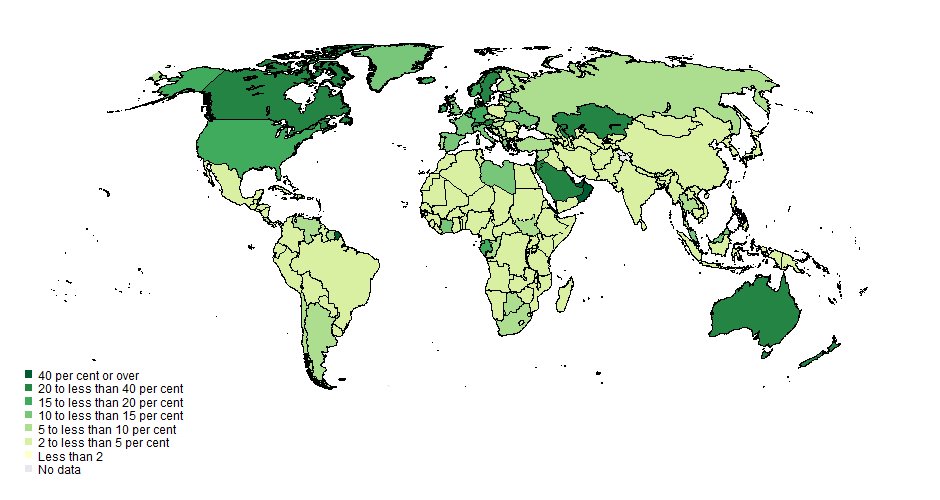
<br>
Every immigrant looks for a better quality of life in the new country than her/his country of origin. A comfortable living with basic facilities are the needs of each immigrant families. Happy immigrants results in better and prosper. 

**Project Description :** <br>
As mentioned in the background, we are trying to solve a real life macro problems of thousands of immigrants flocking to Canada.Immigrants coming to Canada needs a livelihood and hence stays near the economic centre of the country. Toronto becomes the natural choice for immigrants as per [Wikipedia](https://en.wikipedia.org/wiki/Toronto) the city  is an international centre of business, finance, arts, and culture, and is recognized as one of the most multicultural and cosmopolitan cities in the world. <br>
However, an immigrant mooving to a large city like Toronto needs to decide the neighbourhood to stay out of the various choices. Again refrering to [Wikipedia](https://en.wikipedia.org/wiki/Toronto) over the late 20th century and early 21st century, North York City Centre have emerged as secondary business districts outside Downtown Toronto. High-rise development in these areas has given the former municipalities distinguishable skylines of their own with high-density transit corridors serving them. <br>
Thus, this projects aim to create an analysis of features for [**North York neighborhood**](https://en.wikipedia.org/wiki/North_York#cite_note-8). The features include like median house price, school ratings, population rate, crime rates, recreational facilities, etc. The major determinal factors to settle in would be **housing prices** and **ratings of schools**. The end result provides users an overview of the places before they are moving to Toronto as their new country or city as their place for work or to began a new life. <br>
In summary, this Project would assist an immigrant or users have more informed decision on choosing the best neighborhood out of many neighborhoods to move into Tornoto city based on the housing prices and school ratings.

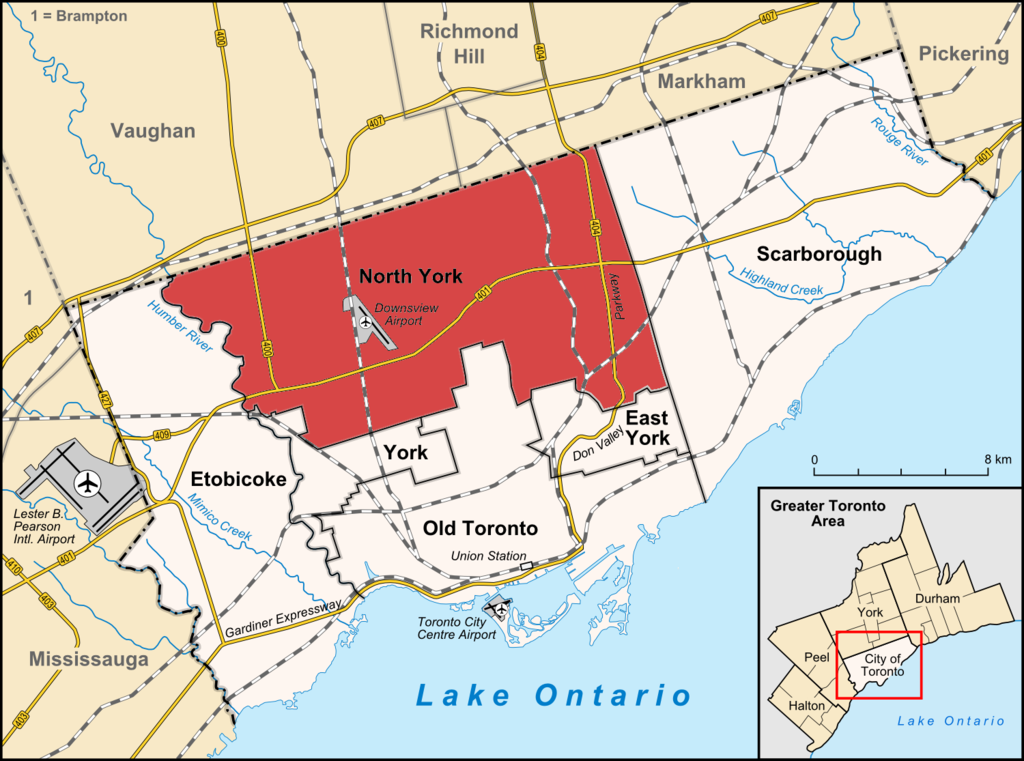

## **1. Imprting the required Python Packages**

In [5]:
import json # library to handle JSON files
import xml
import requests
from bs4 import BeautifulSoup
import pandas as pd #Python library data manipulation and analysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import matplotlib.pyplot as plt
%matplotlib inline

! pip install geocoder
! pip install geopy
import geocoder
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

! pip install folium
import folium # map rendering library
import warnings
warnings.filterwarnings("ignore")

In [6]:
# download url data from internet
url = "https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M"
source = requests.get(url).text
Canada_data = BeautifulSoup(source, 'lxml')

**Data processing -** Now we convert the extracted the content of PostalCode HTML table as dataframe, for further usage.

In [7]:
# creat a new Dataframe
column_names = ['Postalcode','Borough','Neighborhood']
toronto = pd.DataFrame(columns = column_names)

# loop through to find postcode, borough, neighborhood 
content = Canada_data.find('div', class_='mw-parser-output')
table = content.table.tbody
postcode = 0
borough = 0
neighborhood = 0

for tr in table.find_all('tr'):
    i = 0
    for td in tr.find_all('td'):
        if i == 0:
            postcode = td.text
            i = i + 1
        elif i == 1:
            borough = td.text
            i = i + 1
        elif i == 2: 
            neighborhood = td.text.strip('\n').replace(']','')
    toronto = toronto.append({'Postalcode': postcode,'Borough': borough,'Neighborhood': neighborhood},ignore_index=True)

# clean dataframe 
toronto = toronto[toronto.Borough!='Not assigned']
toronto = toronto[toronto.Borough!= 0]
toronto.reset_index(drop = True, inplace = True)
i = 0
for i in range(0,toronto.shape[0]):
    if toronto.iloc[i][2] == 'Not assigned':
        toronto.iloc[i][2] = toronto.iloc[i][1]
        i = i+1
                                 
df = toronto.groupby(['Postalcode','Borough'])['Neighborhood'].apply(', '.join).reset_index()
df.head()

,Postalcode,Borough,Neighborhood
0,M1B,Scarborough,"Rouge, Malvern"
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae


**Data Cleaning -**
The web page data shows missing data. So we need to drop the "None" rows in DataFrame. Thus we will drop any row which contains 'Not assigned' value. All "Not assigned" will be replace to 'NaN' using numpy library. 

In [8]:
df = df.dropna()
empty = 'Not assigned'
df = df[(df.Postalcode != empty ) & (df.Borough != empty) & (df.Neighborhood != empty)]
df.head ()

,Postalcode,Borough,Neighborhood
0,M1B,Scarborough,"Rouge, Malvern"
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae


In [9]:
def neighborhood_list(grouped):    
    return ', '.join(sorted(grouped['Neighborhood'].tolist()))
                    
grp = df.groupby(['Postalcode', 'Borough'])
df2 = grp.apply(neighborhood_list).reset_index(name='Neighborhood')
print(df2.shape)
df2.head()

(103, 3)


,Postalcode,Borough,Neighborhood
0,M1B,Scarborough,"Rouge, Malvern"
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae


## **2. Data Import steps** <br>
Let us find our objective of interest the North York neighbourhood and print its geo cordinates.

In [11]:
address = 'North York,Toronto'

geolocator = Nominatim()
location = geolocator.geocode(address)
latitude_x = location.latitude
longitude_y = location.longitude
print('The geograpical coordinate of North York,Toronto are {}, {}.'.format(latitude_x, longitude_y))

The geograpical coordinate of North York,Toronto are 43.7708175, -79.4132998.


In [12]:
def get_latlng(postal_code):
    # initialize your variable to None
    lat_lng_coords = None
    # loop until you get the coordinates
    while(lat_lng_coords is None):
        g = geocoder.arcgis('{}, Toronto, Ontario'.format(postal_code))
        lat_lng_coords = g.latlng
    return lat_lng_coords
    
# Post Code 'M2', 'M3', 'M4', 'M6', 'M9' are the codes for North York from the Wikipedia list imported above
# Note we are getting an approx geo location/cordinates for the entire Borough of North York and not a single Neighbourhood
get_latlng('M6')

[43.648690000000045, -79.38543999999996]

In [13]:
postal_codes = df['Postalcode']    
coords = [ get_latlng(postal_code) for postal_code in postal_codes.tolist() ]
df_coords = pd.DataFrame(coords, columns=['Latitude', 'Longitude'])
df['Latitude'] = df_coords['Latitude']
df['Longitude'] = df_coords['Longitude']
# Let us get the information for Lawrence Heights neighbourhood out of North York
df[df.Postalcode == 'M6A']

,Postalcode,Borough,Neighborhood,Latitude,Longitude
71,M6A,North York,"Lawrence Heights, Lawrence Manor",43.723125,-79.451589


Let us display the dataframe with the columns of Latitude and Longitude

In [14]:
df.head(5)

,Postalcode,Borough,Neighborhood,Latitude,Longitude
0,M1B,Scarborough,"Rouge, Malvern",43.811525,-79.195517
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union",43.785730,-79.158750
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.765690,-79.175256
3,M1G,Scarborough,Woburn,43.768359,-79.217590
4,M1H,Scarborough,Cedarbrae,43.769688,-79.239440


## **3. Map of the North York neighbourhood in Toronto using Foursquare API**

In [15]:
# create map of Toronto using latitude and longitude values
map_NorthYork = folium.Map(location=[latitude_x, longitude_y], zoom_start=10)

# add markers to map
for lat, lng, nei in zip(df['Latitude'], df['Longitude'], df['Neighborhood']):
    
    label = '{}'.format(nei)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_NorthYork)  
    
map_NorthYork

In [16]:
address = 'North York,Toronto'

geolocator = Nominatim()
location = geolocator.geocode(address)
latitude_n1 = location.latitude
longitude_n1 = location.longitude
print('The geograpical coordinate of neighborhood_1 are {}, {}.'.format(latitude_x, longitude_y))

The geograpical coordinate of neighborhood_1 are 43.7708175, -79.4132998.


In [17]:
CLIENT_ID = '4PNKDBUN0TFTQ3MNDBJ2JA3FGD1GC4YSN2BRLDLLSAMZHLF5' # your Foursquare ID
CLIENT_SECRET = '0LJVFO5RSETDELNBPNAK4AXPV1HLBVI1CFI3V4RI2FX4WRXH' # your Foursquare Secret
VERSION = '20190926' # Foursquare API version

In [18]:
radius = 700 
LIMIT = 100
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    latitude_n1, 
   longitude_n1, 
    radius, 
   LIMIT)
results = requests.get(url).json()

In [19]:
venues=results['response']['groups'][0]['items']
nearby_venues = json_normalize(venues)
nearby_venues.columns

Index(['reasons.count', 'reasons.items', 'referralId', 'venue.categories',
       'venue.events.count', 'venue.events.summary', 'venue.id',
       'venue.location.address', 'venue.location.cc', 'venue.location.city',
       'venue.location.country', 'venue.location.crossStreet',
       'venue.location.distance', 'venue.location.formattedAddress',
       'venue.location.labeledLatLngs', 'venue.location.lat',
       'venue.location.lng', 'venue.location.neighborhood',
       'venue.location.postalCode', 'venue.location.state', 'venue.name',
       'venue.photos.count', 'venue.photos.groups', 'venue.venuePage.id'],
      dtype='object')

In [20]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

## **4. Study of the Nearby Attractions in North York, Toronto**

In [21]:
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]
nearby_venues.head(5)

,venue.name,venue.categories,venue.location.lat,venue.location.lng
0,The Captain's Boil,"[{'id': '4bf58dd8d48988d1ce941735', 'name': 'S...",43.773255,-79.413805
1,Aroma Espresso Bar,"[{'id': '4bf58dd8d48988d16d941735', 'name': 'C...",43.769449,-79.413081
2,Starbucks,"[{'id': '4bf58dd8d48988d1e0931735', 'name': 'C...",43.768353,-79.413046
3,Konjiki Ramen,"[{'id': '55a59bace4b013909087cb24', 'name': 'R...",43.766998,-79.412222
4,The Keg,"[{'id': '4bf58dd8d48988d1cc941735', 'name': 'S...",43.766579,-79.412131


## **5. Let us find and list the Categories of the Nearby Attractions**

In [22]:
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head(10)

,name,categories,lat,lng
0,The Captain's Boil,Seafood Restaurant,43.773255,-79.413805
1,Aroma Espresso Bar,Café,43.769449,-79.413081
2,Starbucks,Coffee Shop,43.768353,-79.413046
3,Konjiki Ramen,Ramen Restaurant,43.766998,-79.412222
4,The Keg,Steakhouse,43.766579,-79.412131
5,Loblaws,Grocery Store,43.768722,-79.412101
6,Cineplex Cinemas Empress Walk,Movie Theater,43.768625,-79.412613
7,Burrito Boyz,Burrito Place,43.773054,-79.414082
8,Toronto Centre for the Arts,Theater,43.766228,-79.414115
9,Wako Sushi + Bar,Japanese Restaurant,43.770806,-79.413138


Though our selection of neighbourhood is dependent on housing price and school ratings, it might be worthwhile for an immigrant to get to know the popular nearby attarcations. Hence, listing the top nearby attraction by categories in North York

In [23]:
a=pd.Series(nearby_venues.categories)
a.value_counts()[:10]

Coffee Shop                  6
Pizza Place                  5
Ramen Restaurant             5
Bubble Tea Shop              5
Fast Food Restaurant         3
Sushi Restaurant             3
Japanese Restaurant          3
Korean Restaurant            3
Middle Eastern Restaurant    2
Café                         2
Name: categories, dtype: int64

In [29]:
def getNearbyVenues(names, latitudes, longitudes, radius=700):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        venue_results = requests.get(url).json()["response"]['groups'][0]['items']
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in venue_results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [30]:
# List names of the nearby venues

Northyork_venues = getNearbyVenues(names=df['Neighborhood'],
                                   latitudes=df['Latitude'],
                                   longitudes=df['Longitude']
                                  )

Rouge, Malvern
Highland Creek, Rouge Hill, Port Union
Guildwood, Morningside, West Hill
Woburn
Cedarbrae
Scarborough Village
East Birchmount Park, Ionview, Kennedy Park
Clairlea, Golden Mile, Oakridge
Cliffcrest, Cliffside, Scarborough Village West
Birch Cliff, Cliffside West
Dorset Park, Scarborough Town Centre, Wexford Heights
Maryvale, Wexford
Agincourt
Clarks Corners, Sullivan, Tam O'Shanter
Agincourt North, L'Amoreaux East, Milliken, Steeles East
L'Amoreaux West
Upper Rouge
Hillcrest Village
Fairview, Henry Farm, Oriole
Bayview Village
Silver Hills, York Mills
Newtonbrook, Willowdale
Willowdale South
York Mills West
Willowdale West
Parkwoods
Don Mills North
Flemingdon Park, Don Mills South
Bathurst Manor, Downsview North, Wilson Heights
Northwood Park, York University
CFB Toronto, Downsview East
Downsview West
Downsview Central
Downsview Northwest
Victoria Village
Woodbine Gardens, Parkview Hill
Woodbine Heights
The Beaches
Leaside
Thorncliffe Park
East Toronto
The Danforth West, 

In [31]:
print('There are {} uniques categories.'.format(len(Northyork_venues['Venue Category'].unique())))
Northyork_venues.groupby('Neighborhood').count().head()

There are 299 uniques categories.


,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
"Adelaide, King, Richmond",100,100,100,100,100,100
Agincourt,25,25,25,25,25,25
"Agincourt North, L'Amoreaux East, Milliken, Steeles East",3,3,3,3,3,3
"Albion Gardens, Beaumond Heights, Humbergate, Jamestown, Mount Olive, Silverstone, South Steeles, Thistletown",12,12,12,12,12,12
"Alderwood, Long Branch",9,9,9,9,9,9


## **One Hot Encoding of categorical variables like the features to Binary values**

In [32]:
# one hot encoding
Northyork_onehot = pd.get_dummies(Northyork_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
Northyork_onehot['Neighborhood'] = Northyork_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [Northyork_onehot.columns[-1]] + list(Northyork_onehot.columns[:-1])
Northyork_onehot = Northyork_onehot[fixed_columns]
Northyork_grouped = Northyork_onehot.groupby('Neighborhood').mean().reset_index()
Northyork_onehot.head(5)

,Zoo Exhibit,Accessories Store,Afghan Restaurant,African Restaurant,Airport,American Restaurant,Animal Shelter,Antique Shop,Arcade,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Dealership,Auto Garage,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Basketball Stadium,Beach,Beer Bar,Beer Store,Belgian Restaurant,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bistro,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bridge,Bubble Tea Shop,Buffet,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Castle,Cemetery,Cheese Shop,Chinese Restaurant,Chiropractor,Chocolate Shop,Church,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Gym,College Rec Center,College Stadium,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Costume Shop,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Cycle Studio,Dance Studio,Deli / Bodega,Dentist's Office,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Doctor's Office,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gaming Cafe,Garden,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Golf Course,Golf Driving Range,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Hakka Restaurant,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hong Kong Restaurant,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indonesian Restaurant,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kitchen Supply Store,Korean Restaurant,Latin American Restaurant,Laundry Service,Leather Goods Store,Library,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Luggage Store,Mac & Cheese Joint,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Mattress Store,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Movie Theater,Moving Target,Museum,Music Venue,Neighborhood,New American Restaurant,Nightclub,Noodle House,Office,Optical Shop,Organic Grocery,Other Great Outdoors,Other Nightlife,Paper / Office Supplies Store,Park,Pastry Shop,Performing Arts Venue,Persian Restaurant,Peruvian Restaurant,Pet Store,Pharmacy,Photography Lab,Pilates Studio,Pizza Place,Platform,Playground,Plaza,Poke Place,Polish Restaurant,Pool,Pool Hall,Portuguese Restaurant,Poutine Place,Print Shop,Pub,Ramen Restaurant,Record Shop,Rental Car Location,Residential Building (Apartment / Condo),Restaurant,Road,Rock Climbing Spot,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Science Museum,Sculpture Garden,Seafood Restaurant,Shanghai Restaurant,Shipping Store,Shoe Store,Shop & Service,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Soccer Stadium,Social Club,Soup Place,Southern / Soul Food Restaurant,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Sports Club,Sri Lankan Restaurant,Stationery Store,Steakhouse,Storage Facility,Supermarket,Sushi Restaurant,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tapas Restaurant,Tea Room,Tech Startup,T

For each of the neighbourhood let us list the top 5 venue frequency - keeping in mind all options open for the immigrant while decision making

In [33]:
num_top_venues = 5
for hood in Northyork_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp =Northyork_grouped[Northyork_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Adelaide, King, Richmond----
         venue  freq
0  Coffee Shop  0.09
1         Café  0.07
2        Hotel  0.06
3          Bar  0.03
4   Steakhouse  0.03


----Agincourt----
                 venue  freq
0        Shopping Mall  0.12
1   Chinese Restaurant  0.12
2                 Pool  0.04
3             Pharmacy  0.04
4  Shanghai Restaurant  0.04


----Agincourt North, L'Amoreaux East, Milliken, Steeles East----
                  venue  freq
0              Pharmacy  0.67
1        Sandwich Place  0.33
2           Zoo Exhibit  0.00
3             Nightclub  0.00
4  Other Great Outdoors  0.00


----Albion Gardens, Beaumond Heights, Humbergate, Jamestown, Mount Olive, Silverstone, South Steeles, Thistletown----
                  venue  freq
0         Grocery Store  0.17
1   Fried Chicken Joint  0.08
2              Pharmacy  0.08
3  Fast Food Restaurant  0.08
4            Beer Store  0.08


----Alderwood, Long Branch----
            venue  freq
0             Pub  0.11
1     Pizza Place  

                venue  freq
0         Coffee Shop  0.12
1                Café  0.07
2               Hotel  0.07
3          Restaurant  0.04
4  Seafood Restaurant  0.03


----Flemingdon Park, Don Mills South----
                 venue  freq
0                  Gym  0.08
1           Beer Store  0.08
2  Japanese Restaurant  0.08
3       Science Museum  0.08
4     Asian Restaurant  0.08


----Forest Hill North, Forest Hill West----
                           venue  freq
0                           Café  0.18
1                   Burger Joint  0.09
2  Vegetarian / Vegan Restaurant  0.09
3                            Gym  0.09
4                           Bank  0.09


----Glencairn----
                       venue  freq
0                Pizza Place  0.20
1              Grocery Store  0.13
2       Fast Food Restaurant  0.13
3        Japanese Restaurant  0.07
4  Latin American Restaurant  0.07


----Guildwood, Morningside, West Hill----
                        venue  freq
0                        

         venue  freq
0  Coffee Shop  0.08
1         Café  0.07
2          Bar  0.04
3        Hotel  0.04
4   Steakhouse  0.04


----Studio District----
            venue  freq
0            Café  0.05
1     Coffee Shop  0.05
2           Diner  0.05
3          Bakery  0.05
4  Sandwich Place  0.04


----The Annex, North Midtown, Yorkville----
                           venue  freq
0                           Café  0.09
1                    Coffee Shop  0.09
2             Italian Restaurant  0.07
3                 Sandwich Place  0.07
4  Vegetarian / Vegan Restaurant  0.05


----The Beaches----
                 venue  freq
0                  Spa  0.07
1                  Bar  0.07
2  Japanese Restaurant  0.07
3                  Pub  0.07
4       Sandwich Place  0.03


----The Beaches West, India Bazaar----
            venue  freq
0            Park  0.09
1         Brewery  0.06
2          Bakery  0.06
3      Donut Shop  0.06
4  Sandwich Place  0.06


----The Danforth West, Riverdale----
    

## **6. Let us get details of the most common venues near Neighborhood**

In [34]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [35]:
import numpy as np
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = Northyork_grouped['Neighborhood']

for ind in np.arange(Northyork_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(Northyork_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Adelaide, King, Richmond",Coffee Shop,Café,Hotel,Steakhouse,Gastropub,Burger Joint,Breakfast Spot,Bar,Restaurant,American Restaurant
1,Agincourt,Chinese Restaurant,Shopping Mall,Malay Restaurant,Shanghai Restaurant,Sushi Restaurant,Supermarket,Breakfast Spot,Mediterranean Restaurant,Skating Rink,Seafood Restaurant
2,"Agincourt North, L'Amoreaux East, Milliken, St...",Pharmacy,Sandwich Place,Yoga Studio,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant
3,"Albion Gardens, Beaumond Heights, Humbergate, ...",Grocery Store,Coffee Shop,Fast Food Restaurant,Beer Store,Liquor Store,Pizza Place,Park,Hardware Store,Sandwich Place,Pharmacy
4,"Alderwood, Long Branch",Coffee Shop,Gym,Convenience Store,Gas Station,Pub,Pizza Place,Sandwich Place,Pharmacy,Dance Studio,Donut Shop


## **7. Clustering of the neighbourhood by k-means**

In [36]:
# sfirst we need to set number of clusters
# For using k-means technique, let us assign the neighborhood into 3 clusters.

Northyork_grouped_clustering = Northyork_grouped.drop('Neighborhood', 1)
#Northyor_grouped_clustering = Northyork_grouped

# run k-means clustering
kmeans = KMeans(n_clusters=3, random_state=0).fit(Northyork_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_

array([0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0,
       0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [37]:
Northyork_merged =df.iloc[:102,:]

# add clustering labels
Northyork_merged['Cluster Labels'] = kmeans.labels_

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
Northyork_merged = Northyork_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

Northyork_merged.head()# check the last columns!

,Postalcode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M1B,Scarborough,"Rouge, Malvern",43.811525,-79.195517,0,Zoo Exhibit,Business Service,Fast Food Restaurant,Construction & Landscaping,African Restaurant,Costume Shop,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union",43.785730,-79.158750,0,Bar,Fish & Chips Shop,Yoga Studio,Farm,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.765690,-79.175256,0,Construction & Landscaping,Athletics & Sports,Gym / Fitness Center,Park,Cuban Restaurant,Falafel Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store
3,M1G,Scarborough,Woburn,43.768359,-79.217590,0,Coffee Shop,Park,Fast Food Restaurant,Business Service,Yoga Studio,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space
4,M1H,Scarborough,Cedarbrae,43.769688,-79.239440,0,Bakery,Indian Restaurant,Thai Restaurant,Caribbean Restaurant,Athletics & Sports,Hakka Restaurant,Bank,Field,Fast Food Restaurant,Farmers Market


In [40]:
df1=Northyork_merged.loc[Northyork_merged['Cluster Labels'] == 0,Northyork_merged.columns[[2] + list(range(5, Northyork_merged.shape[1]))]]
df2=Northyork_merged.loc[Northyork_merged['Cluster Labels'] == 1,Northyork_merged.columns[[2] + list(range(5, Northyork_merged.shape[1]))]]
df3=Northyork_merged.loc[Northyork_merged['Cluster Labels'] == 2,Northyork_merged.columns[[2] + list(range(5, Northyork_merged.shape[1]))]]

Now we do some extensive **secondary research over websites** to find the **average housing price** for these over 100 neighbourhoods. As there is no sigle website that provides the average housing price in one place or one table. We collect information from 3 websites namely [Numbeo](https://www.numbeo.com/cost-of-living/in/Toronto), [Point2homes](https://www.point2homes.com/CA/Real-Estate-Listings/ON/Toronto.html) and [Squarespace Report](https://static1.squarespace.com/static/546bbd2ae4b077803c592197/t/5c5c92ae15fcc0cc392edc40/1549570776033/CUIPublication.TorontoHousingMarketAnalysis.2019.pdf) and collate the information. 

In [41]:
Northyork_Avg_HousingPrice=pd.DataFrame({"Neighborhood":df["Neighborhood"],
                                      "Average_Housing_Price":[366075.481758162,163318.970411637,220978.026509011,147227.624544043,202568.570503789,60231.8148043941,
                                                               14327.8983694175,349600.115679018,14811.2693516714,366249.605534228,105016.132187111,253672.719690121,
                                                               299093.91356158,229239.095989459,236429.483766331,368839.296188594,121733.166906974,85194.8844421614,
                                                               302602.552218079,174611.899936914,2320.61272866879,224491.620051229,339796.615702684,290529.480688612,
                                                               89990.3881646178,54199.0000572583,44997.3594395527,96934.6934682827,12929.5917503819,87721.8786758391,
                                                               160235.00299588,52817.6643228872,34501.7810573322,168019.926849958,322030.512696482,361162.202928179,
                                                               121723.854346667,55856.8319327559,340731.213252631,195196.739840888,225006.41159555,83738.0441623952,
                                                               1450.64781544136,270104.384299256,340373.396607553,41630.1663087499,222741.344556362,65095.8533969753,
                                                               244439.735316016,39724.3920045717,362629.089772455,160892.706462714,242015.504943107,70927.2235402657,
                                                               149272.642434381,165790.929671038,255724.106300572,332024.414660058,71864.0385732659,348822.0994793,
                                                               52939.2038742798,316323.777971848,315300.72101476,13794.4485155377,113120.407836048,285537.87720101,
                                                               82068.3734967374,177660.75200708,96478.8321590437,246249.18660315,155098.800338312,145218.073703072,
                                                               103121.387433319,325240.219046531,19404.1597201802,168356.723070739,245989.16742277,40861.1811045872,
                                                               215978.167596395,246289.310680731,110763.68741626,304727.295175501,172405.333263367,176922.51670258,
                                                               158161.161859158,125349.356882793,289121.948829413,341607.195543182,369452.316730356,313242.913025458,
                                                               101695.703193633,250495.477214349,336414.528826521,31658.0354517312,264971.572536506,202848.668268697,
                                                               198328.985117576,60781.6932301877,44357.5639886286,229288.987444567,107483.595350118,165811.165277597,
                                                               271109.386357118]})

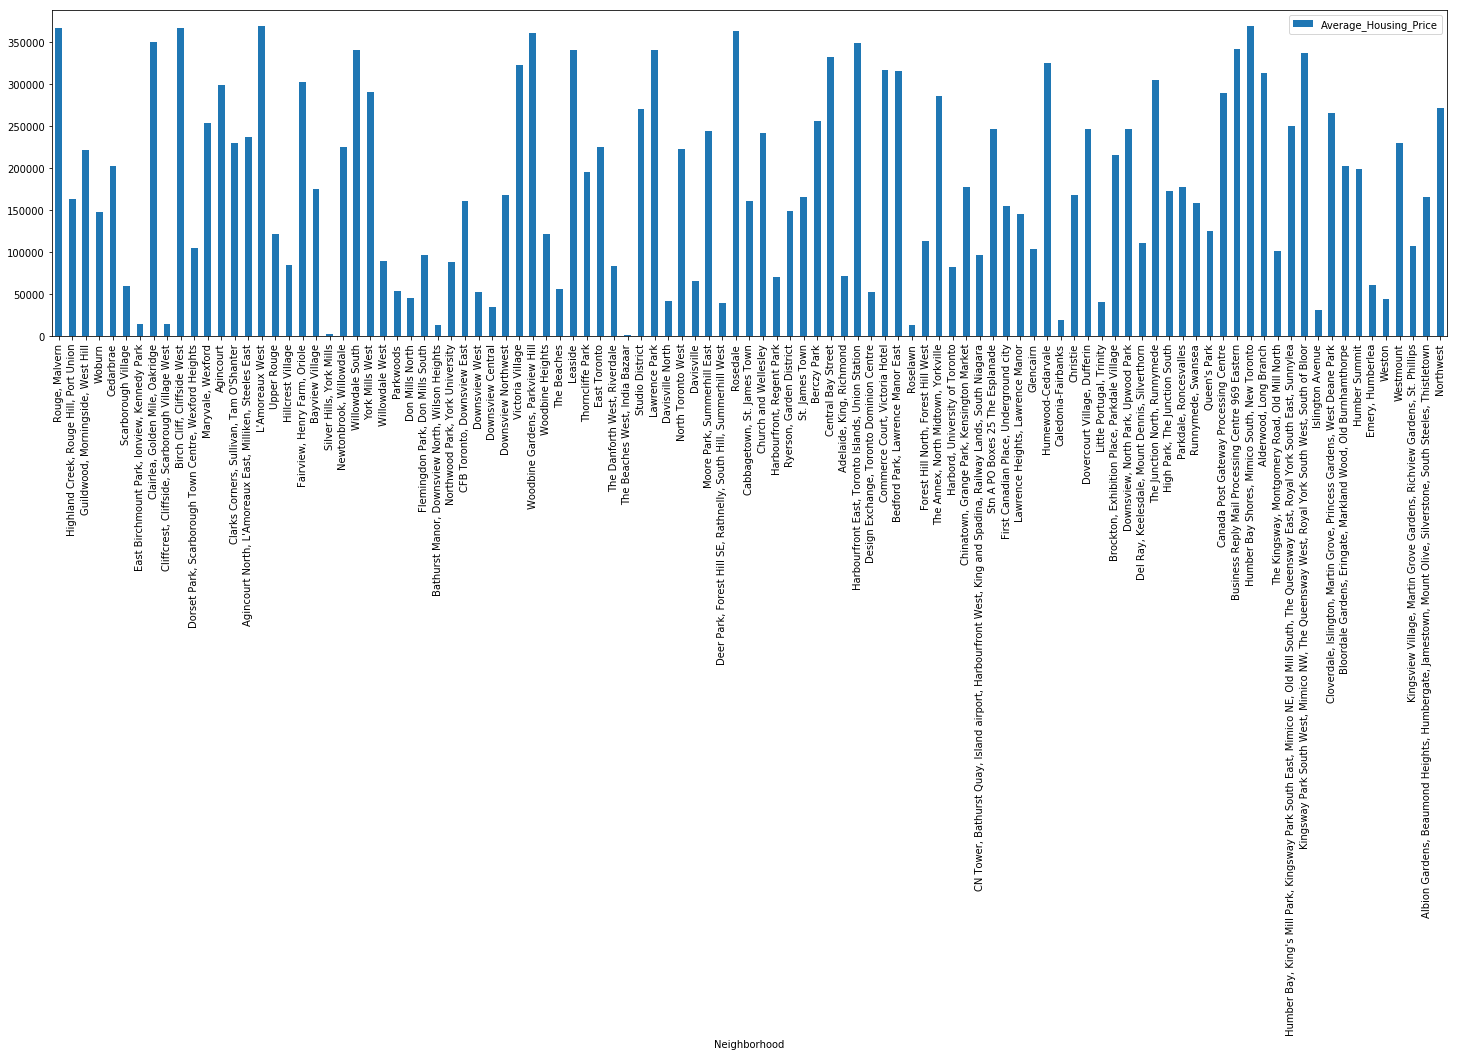

In [42]:
#Bar Chart of Average Housing Price for each of the neighbourhood
Northyork_Avg_HousingPrice.set_index('Neighborhood',inplace=True,drop=True)
Northyork_Avg_HousingPrice.plot(kind='bar',figsize=(25,6),alpha=1.00)

## **School Rating by Clusters**
We face the same problem with the **school ratings of the neighbourhoods**. There is no single website or a report that provides this information in one table or place. <br> So we use various filters and arrive at the school ratings for the neighbourhood using [Compare School Rankings](http://ontario.compareschoolrankings.org/elementary/SchoolsByRankLocationName.aspx?schooltype=elementary) website. <br> *Note we use only elemantary school rankings here for simplicity in decision making*.

In [45]:
# create map
map_clusters = folium.Map(location=[latitude_x, longitude_y], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
colors_array = cm.rainbow(np.linspace(0, 1, kclusters))
rainbow = [colors.rgb2hex(i) for i in colors_array]
print(rainbow)
# add markers to the map
markers_colors = []
for lat, lon, nei , cluster in zip(Northyork_merged['Latitude'], 
                                   Northyork_merged['Longitude'], 
                                   Northyork_merged['Neighborhood'], 
                                   Northyork_merged['Cluster Labels']):
    label = folium.Popup(str(nei) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_cluster

clusters=pd.DataFrame({"Cluster1":df1["Neighborhood"],
                      "Cluster2":df2["Neighborhood"],
                      "Cluster4":df3["Neighborhood"]})
clusters = clusters.replace(np.nan, '', regex=True

SyntaxError: unexpected EOF while parsing (<ipython-input-45-9df1d7bf5952>, line 30)

In [46]:
new_Northyork=Northyork_merged.set_index("Neighborhood",drop=True)
Northyork_school_ratings=pd.DataFrame({"Neighborhood":df["Neighborhood"],
                                      "Top School Rating":[4,5,3,5,8,9,1,5,4,8,2,0,0,6,4,7,
                                                           2,6,1,5,7,8,1,0,0,7,8,1,4,1,8,1,
                                                           3,3,7,6,2,6,9,9,2,7,4,1,3,8,3,8,
                                                           8,5,5,1,7,0,3,7,5,1,4,6,6,5,7,3,
                                                           5,9,1,7,4,9,1,4,3,3,4,4,6,8,2,2,
                                                           7,8,4,1,2,7,0,9,1,0,5,4,3,4,8,7,
                                                           0,0,3,0,9,8,0,]})

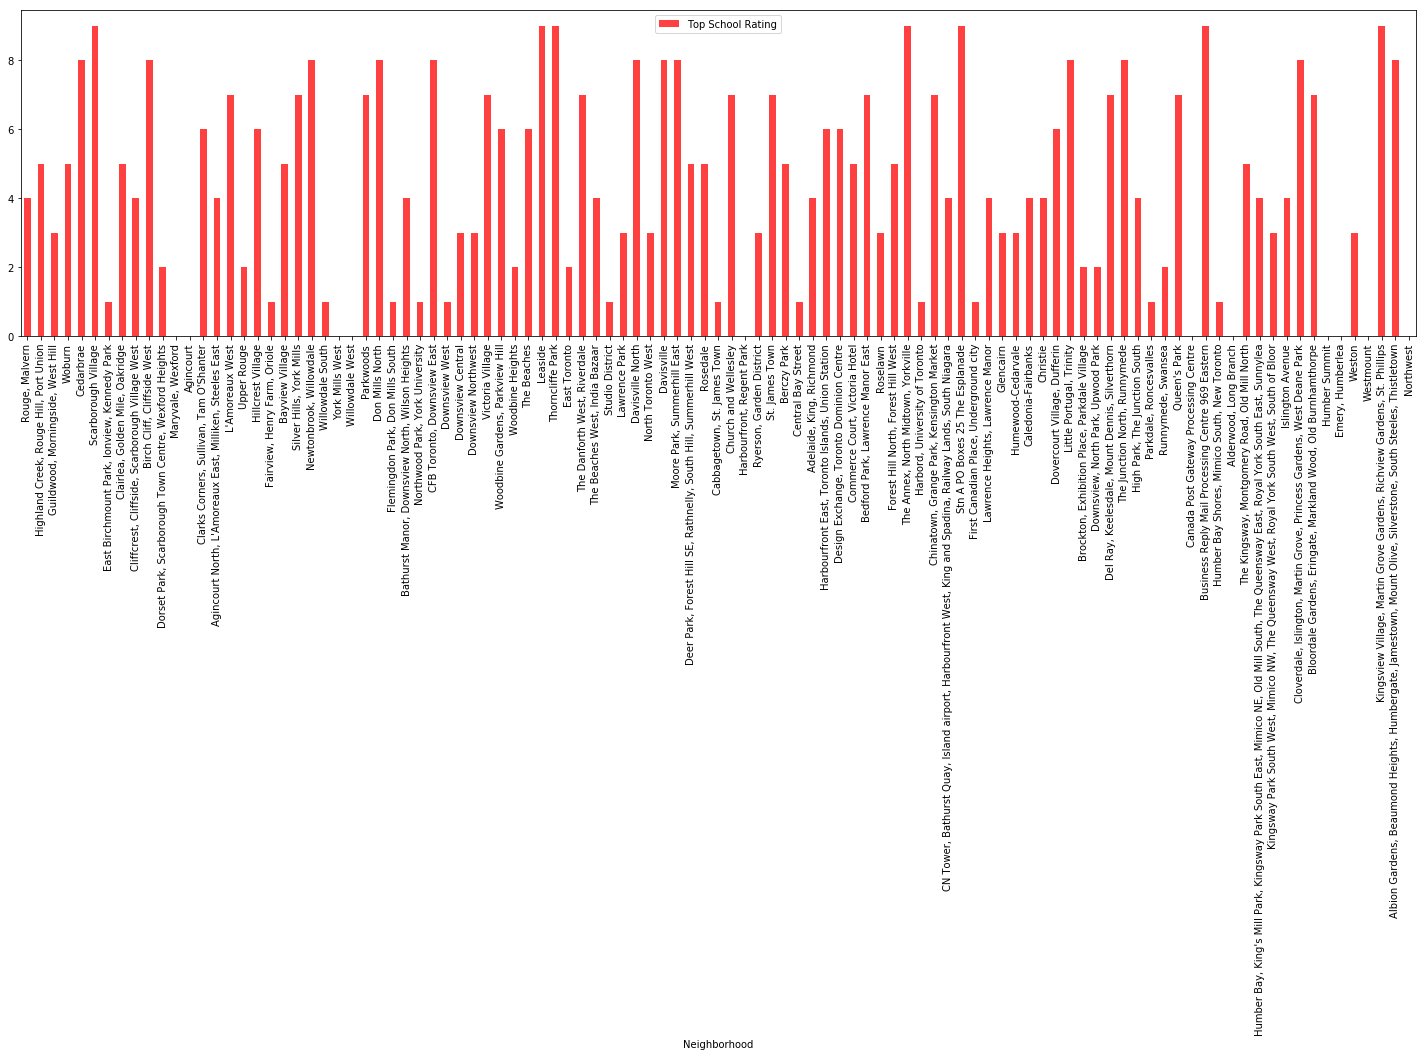

In [47]:
#Bar Chart of Average School Ratings for each of the neighbourhood
Northyork_school_ratings.set_index('Neighborhood',inplace=True,drop=True)
Northyork_school_ratings.plot(kind='bar',figsize=(25,6),color='red',alpha=0.75)

## **8. Finally, we will deep dive and name the neighbourhoods in North York, Toronto for the immigrants**

Both the charts are a good visual of the two factors i.e. average housing price and school ratings of the neighbourhoods. However, as North York as a borough occours in multiple post codes (M2, M3, M6, etc.) it brings in the chart neighbourhoods from other borough also. So we create a simple excel file with the 102 neighbourhoods names listed above and two colums containing the average housing price and school ratings. <br>
Using ranking method we arrive at the probable best neighbourhoods in North York, Toronto.

In [48]:
#reading the Excel file 
import pandas as pd
df = pd.read_excel(r'C:\Users\U327390\OneDrive - Danfoss\Desktop\Python.xlsx') 
print (df)

                                   Neighbourhood Names  School Ratings  \
0                                       Rouge, Malvern               4   
1               Highland Creek, Rouge Hill, Port Union               5   
2                    Guildwood, Morningside, West Hill               3   
3                                               Woburn               5   
4                                            Cedarbrae               8   
5                                  Scarborough Village               9   
6          East Birchmount Park, Ionview, Kennedy Park               1   
7                      Clairlea, Golden Mile, Oakridge               5   
8      Cliffcrest, Cliffside, Scarborough Village West               4   
9                          Birch Cliff, Cliffside West               8   
10   Dorset Park, Scarborough Town Centre, Wexford ...               2   
11                                   Maryvale, Wexford               0   
12                                    

In [49]:
# Ranking of School Ratings descending order
df['School Ratings_Rank']=df['School Ratings'].rank(ascending=0)
df

,Neighbourhood Names,School Ratings,Housing Price Ratings,School Ratings_Rank
0,"Rouge, Malvern",4,366075.481758,55.0
1,"Highland Creek, Rouge Hill, Port Union",5,163318.970412,43.5
2,"Guildwood, Morningside, West Hill",3,220978.026509,67.0
3,Woburn,5,147227.624544,43.5
4,Cedarbrae,8,202568.570504,13.5
5,Scarborough Village,9,60231.814804,4.0
6,"East Birchmount Park, Ionview, Kennedy Park",1,14327.898369,86.0
7,"Clairlea, Golden Mile, Oakridge",5,349600.115679,43.5
8,"Cliffcrest, Cliffside, Scarborough Village West",4,14811.269352,55.0
9,"Birch Cliff, Cliffside West",8,366249.605534,13.5


In [50]:
# Ranking of Housing Price Ratings ascending order
df['Housing Price Ratings']=df['Housing Price Ratings'].rank(ascending=1)
df

,Neighbourhood Names,School Ratings,Housing Price Ratings,School Ratings_Rank
0,"Rouge, Malvern",4,100.0,55.0
1,"Highland Creek, Rouge Hill, Port Union",5,47.0,43.5
2,"Guildwood, Morningside, West Hill",3,61.0,67.0
3,Woburn,5,41.0,43.5
4,Cedarbrae,8,58.0,13.5
5,Scarborough Village,9,19.0,4.0
6,"East Birchmount Park, Ionview, Kennedy Park",1,5.0,86.0
7,"Clairlea, Golden Mile, Oakridge",5,97.0,43.5
8,"Cliffcrest, Cliffside, Scarborough Village West",4,6.0,55.0
9,"Birch Cliff, Cliffside West",8,101.0,13.5


In [51]:
# Calculating the average of the two ranks and inserting a new column
col = df.loc[: , "Housing Price Ratings":"School Ratings_Rank"]
df['Ranking_avg'] = col.mean(axis=1)
df

,Neighbourhood Names,School Ratings,Housing Price Ratings,School Ratings_Rank,Ranking_avg
0,"Rouge, Malvern",4,100.0,55.0,77.50
1,"Highland Creek, Rouge Hill, Port Union",5,47.0,43.5,45.25
2,"Guildwood, Morningside, West Hill",3,61.0,67.0,64.00
3,Woburn,5,41.0,43.5,42.25
4,Cedarbrae,8,58.0,13.5,35.75
5,Scarborough Village,9,19.0,4.0,11.50
6,"East Birchmount Park, Ionview, Kennedy Park",1,5.0,86.0,45.50
7,"Clairlea, Golden Mile, Oakridge",5,97.0,43.5,70.25
8,"Cliffcrest, Cliffside, Scarborough Village West",4,6.0,55.0,30.50
9,"Birch Cliff, Cliffside West",8,101.0,13.5,57.25


In [52]:
#Lastly we have the top to worst neighbourhoods (where top = lowest average housing price with highest school rankings)
df.sort_values(by=['Ranking_avg'])

,Neighbourhood Names,School Ratings,Housing Price Ratings,School Ratings_Rank,Ranking_avg
5,Scarborough Village,9,19.0,4.0,11.50
77,"Little Portugal, Trinity",8,11.0,13.5,12.25
45,Davisville North,8,12.0,13.5,12.75
20,"Silver Hills, York Mills",7,2.0,25.5,13.75
26,Don Mills North,8,14.0,13.5,13.75
47,Davisville,8,21.0,13.5,17.25
100,"Kingsview Village, Martin Grove Gardens, Richv...",9,34.0,4.0,19.00
25,Parkwoods,7,17.0,25.5,21.25
41,"The Danforth West, Riverdale",7,25.0,25.5,25.25
60,"Design Exchange, Toronto Dominion Centre",6,16.0,35.0,25.50


**So the top 3 neighbourhoods in North York are Silver Hills, Don Mills North and Parkwoods.**